In [413]:
import sys
sys.path.insert(0, '..')

In [414]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [415]:
wid = 64
oversample = 4

nwavels = 10

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)


#ddir = "../data/MAST_2024-09-08T07_59_18.213Z/"
#fname = ddir + 'HST/n43ca5feq_cal.fits'

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


exposures = [

    exposure_from_file(ddir + 'n8yj03tgq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),

    exposure_from_file(ddir + 'n8yj02wyq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),
    #exposure_from_file(ddir + 'n8yj02x0q_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),

    #exposure_from_file(fname, SinglePointFit(), crop=wid),
    exposure_from_file(ddir + 'n8yj53vfq_cal.fits', SinglePointSpectrumFit(nwavels), crop=wid),
    #exposure_from_file(ddir + 'n8yj03tiq_cal.fits', SinglePointFit(), crop=wid),

]

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj03tgq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     315   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj02wyq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     315   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71  

In [416]:
exposures[0].filter

'F110W'

In [417]:
y,x = numpy.unravel_index(numpy.nanargmax(exposures[0].data),exposures[0].data.shape)
print(x,y)

32 31


In [418]:
exposures[0].filter

'F110W'

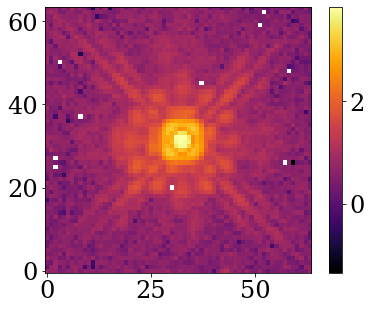

In [419]:
plt.imshow(np.log10(exposures[0].data/exposures[0].err))
plt.colorbar()

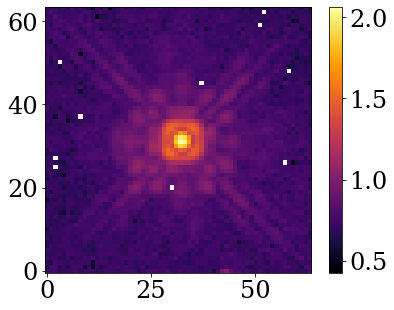

In [420]:
plt.imshow(exposures[0].data**0.125)
plt.colorbar()

In [ ]:
params = {
    "fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.log10(np.nansum(exp.data))
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(nwavels)#.at[0].set(1)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    #params["breathing"][exp.fit.get_key(exp, "breathing")] = np.zeros(19) + 0.1
    #params["start_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    #params["end_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([-0.06, 0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [422]:
params

ModelParams(
  params={
    'fluxes':
    {'U10742_F110W': f32[], 'U11296_F110W': f32[], 'U10764_F110W': f32[]},
    'positions':
    {'n8yj03tgq': f32[2], 'n8yj02wyq': f32[2], 'n8yj53vfq': f32[2]},
    'spectrum':
    {'U10742_F110W': f32[10], 'U11296_F110W': f32[10], 'U10764_F110W': f32[10]},
    'aberrations':
    {'n8yj03tgq': f32[26], 'n8yj02wyq': f32[26], 'n8yj53vfq': f32[26]},
    'cold_mask_shift':
    {'F110W': f32[2]},
    'cold_mask_rot':
    {'F110W': -45.0},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_shear':
    {'F110W': f32[2]},
    'outer_radius':
    1.146,
    'secondary_radius':
    0.44639999999999996,
    'spider_width':
    0.0924,
    'scale':
    0.0432,
    'rot':
    0.0,
    'softening':
    2.0
  }
)

In [423]:
print(params.params)

{'fluxes': {'U10742_F110W': Array(3.5862484, dtype=float32), 'U11296_F110W': Array(3.7139785, dtype=float32), 'U10764_F110W': Array(3.4618218, dtype=float32)}, 'positions': {'n8yj03tgq': Array([0., 0.], dtype=float32), 'n8yj02wyq': Array([0., 0.], dtype=float32), 'n8yj53vfq': Array([0., 0.], dtype=float32)}, 'spectrum': {'U10742_F110W': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), 'U11296_F110W': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), 'U10764_F110W': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)}, 'aberrations': {'n8yj03tgq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'n8yj02wyq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'n8yj53vfq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0

In [424]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*10, 0),
    "cold_mask_shift": opt(g*500, 120),
    "cold_mask_rot": opt(g*100, 120),
    #"cold_mask_scale": opt(g*1000, 150),
    #"cold_mask_shear": opt(g*10, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    "aberrations": opt(g*1.5,120),
    "spectrum": opt(g*0.1, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [425]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [426]:
rc = True
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [427]:
fishers

{'n8yj03tgq': {'fluxes': Array([[4.9582536e+09]], dtype=float32),
  'positions': Array([[ 2.9050851e+08, -1.1171193e+07],
         [-1.1171163e+07,  2.8504886e+08]], dtype=float32),
  'cold_mask_shift': Array([[-10336380.  ,    -81803.46],
         [   -81803.46,  -7228105.  ]], dtype=float32),
  'cold_mask_rot': Array([[-11841481.]], dtype=float32),
  'aberrations': Array([[-1.02618291e+04, -9.54255676e+01,  1.18773804e+03,
           2.21607422e+02, -3.93788159e+03,  1.64316727e+02,
           2.57074646e+02, -1.00486829e+03,  6.71549225e+01,
           9.98048096e+02, -4.30760376e+02,  2.17271576e+02,
          -5.33751172e+03,  1.87955139e+02, -3.10291176e+01,
           6.74989080e+00,  1.63518646e+02,  6.30585327e+01,
           8.82057715e+03, -3.85630615e+02, -1.21013269e+03,
          -4.67231255e+01, -3.72017059e+02,  4.28103180e+02,
           2.58524647e+01, -7.29825516e+01],
         [-9.54255524e+01, -1.48863203e+04,  1.15502724e+02,
          -3.56049048e+03, -1.18269798

In [428]:
lrs.params

{'aberrations': {'n8yj02wyq': Array([1.0600163e-04, 6.7471912e-05, 5.9952454e-05, 1.8777650e-04,
         1.2620473e-04, 2.2394519e-04, 2.5421867e-04, 1.5332467e-04,
         5.8116326e-05, 7.0382019e-05, 8.5171363e-05, 7.2525705e-05,
         1.0207317e-04, 1.4780348e-04, 1.0123180e-04, 9.9623066e-05,
         9.9147335e-05, 9.6381489e-05, 7.3600815e-05, 6.6450106e-05,
         5.7109974e-05, 5.2291714e-05, 6.2803309e-05, 9.4369403e-05,
         7.8544857e-05, 9.4027579e-05], dtype=float32),
  'n8yj03tgq': Array([9.74485156e-05, 6.71757662e-05, 5.54441576e-05, 1.14120332e-04,
         1.13463058e-04, 1.88909617e-04, 1.84370831e-04, 1.37931085e-04,
         5.04317213e-05, 6.40606158e-05, 8.04666342e-05, 6.83583130e-05,
         8.86459966e-05, 1.17020965e-04, 8.30950376e-05, 8.61721055e-05,
         9.34988857e-05, 9.05397465e-05, 6.74224066e-05, 6.15866447e-05,
         5.07817858e-05, 4.82017458e-05, 5.80557826e-05, 8.99605730e-05,
         7.54464636e-05, 8.34915045e-05], dtype=flo

In [429]:
model

NICMOSModel(
  params={
    'aberrations':
    {'n8yj02wyq': f32[26], 'n8yj03tgq': f32[26], 'n8yj53vfq': f32[26]},
    'cold_mask_rot':
    {'F110W': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'F110W': f32[2]},
    'fluxes':
    {'U10742_F110W': f32[], 'U10764_F110W': f32[], 'U11296_F110W': f32[]},
    'outer_radius':
    f32[],
    'positions':
    {'n8yj02wyq': f32[2], 'n8yj03tgq': f32[2], 'n8yj53vfq': f32[2]},
    'primary_rot':
    {'F110W': f32[]},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_shear':
    {'F110W': f32[2]},
    'rot':
    f32[],
    'scale':
    f32[],
    'secondary_radius':
    f32[],
    'softening':
    f32[],
    'spectrum':
    {'U10742_F110W': f32[10], 'U10764_F110W': f32[10], 'U11296_F110W': f32[10]},
    'spider_width':
    f32[]
  },
  filters={'F110W': f32[15,2]},
  optics=NICMOSOptics(
    wf_npixels=512,
    diameter=f32[],
    layers={
      'CompoundApert

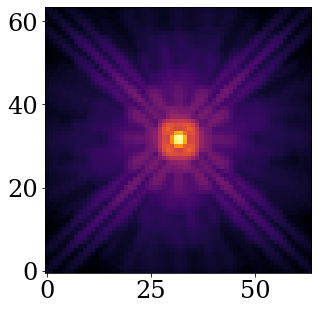

In [430]:
plt.imshow(exposures[0].fit(model,exposures[0])**0.125)

In [431]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(500)):
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)
    
    #if i == 200:
    #    params.set("softening", 0.2)

    models.append(params)
    losses.append(loss)


  0%|          | 0/500 [00:00<?, ?it/s]

In [432]:
#model


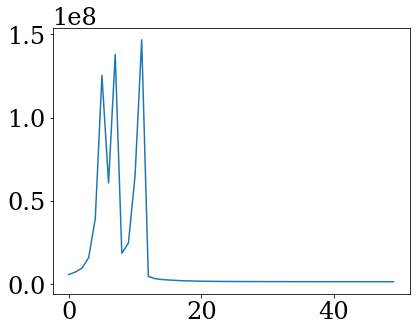

In [433]:
plt.plot(losses[-50:])

6


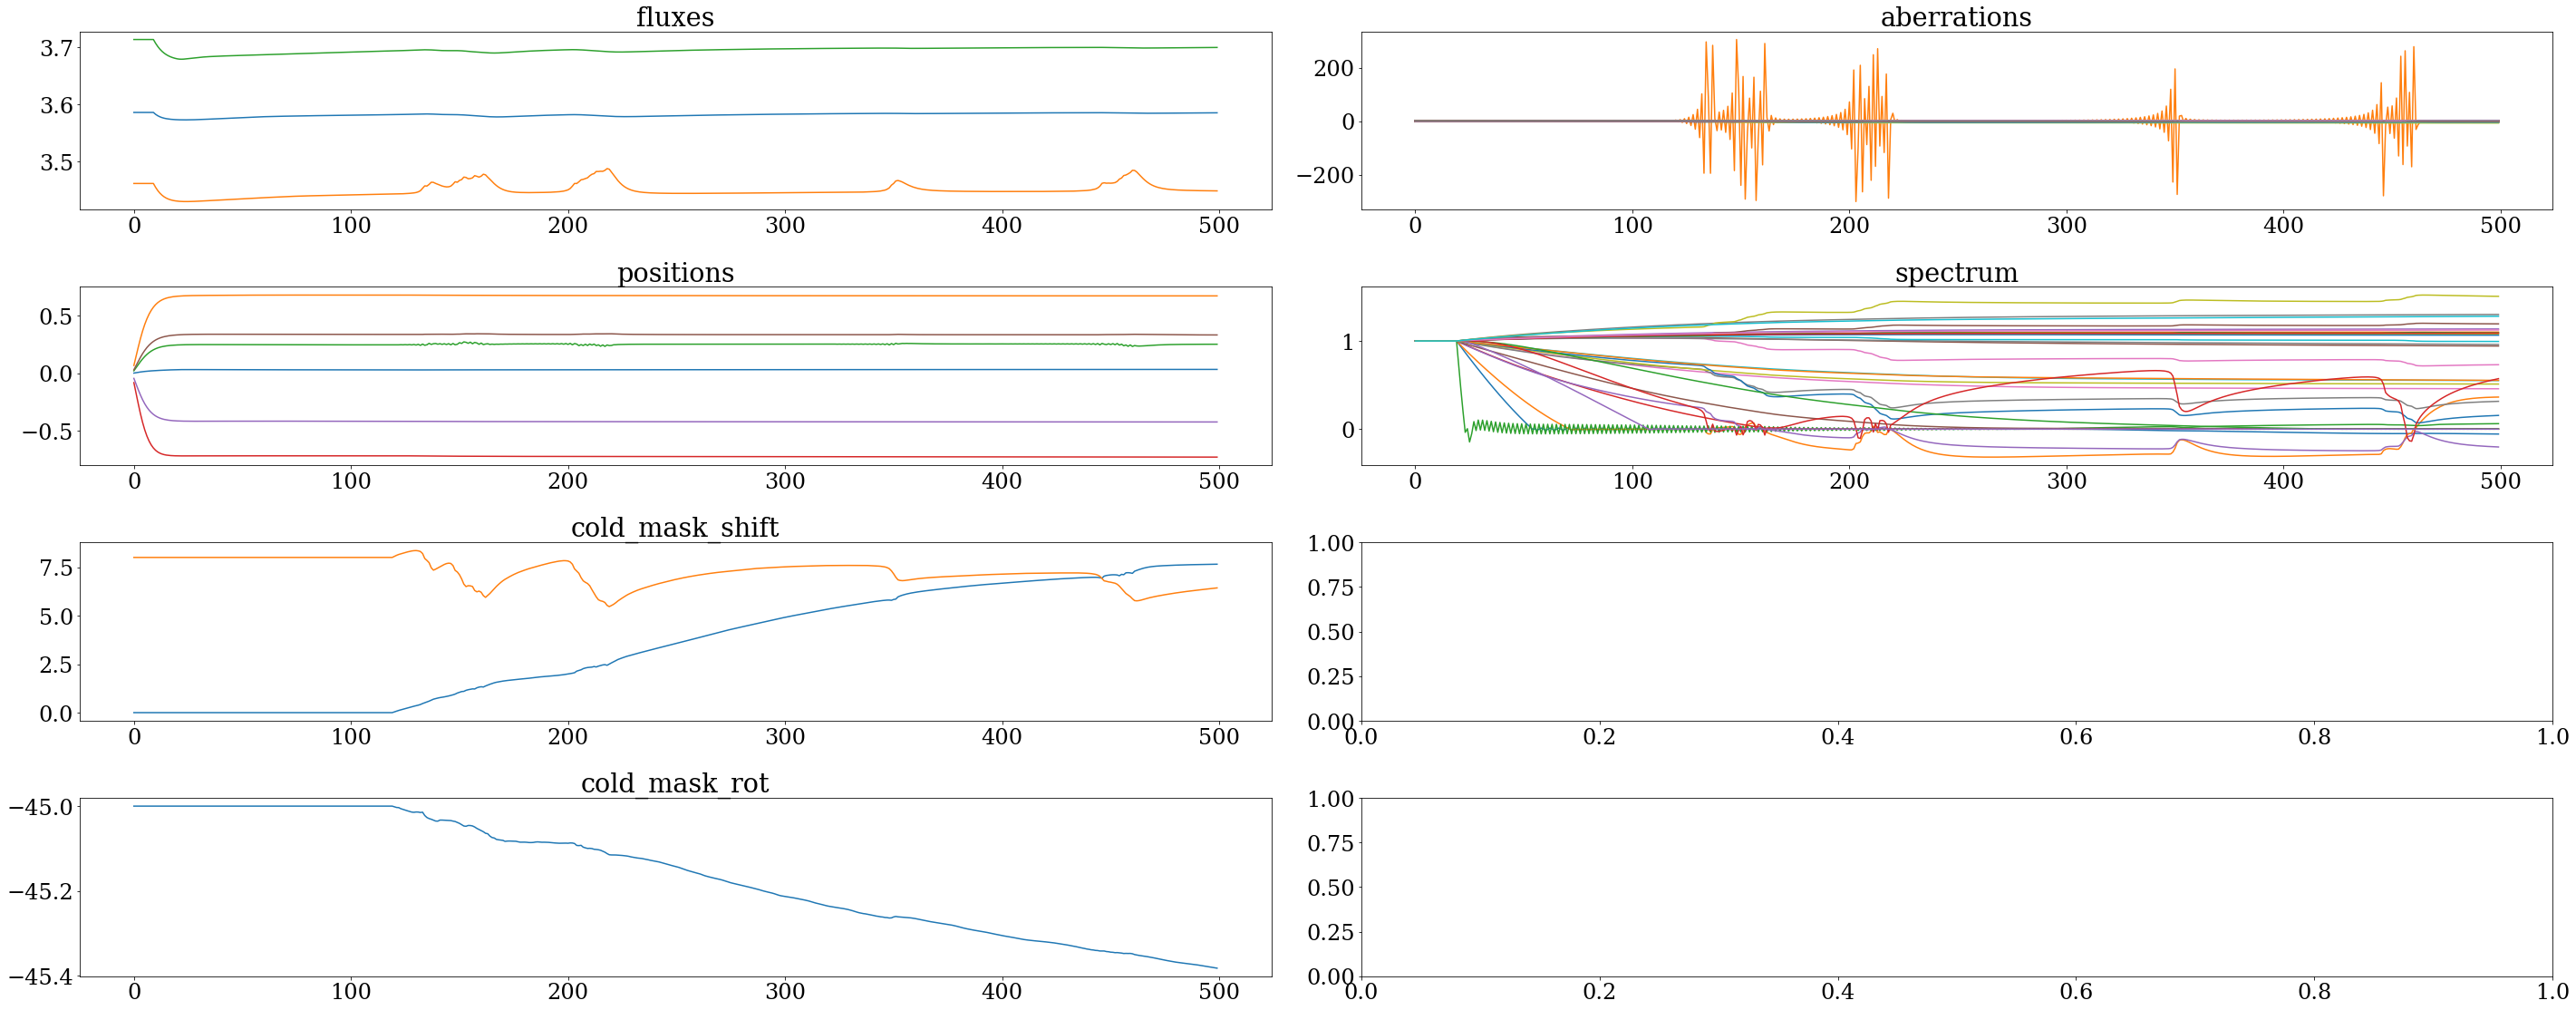

In [434]:
xw = 4
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", 
                 "cold_mask_shift", "cold_mask_rot", "cold_mask_scale", "cold_mask_shear",
                 "primary_rot","primary_scale", "primary_shear", "breathing", "slope", "spectrum"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        """for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')"""
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        #sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

In [435]:
#for exp in exposures:
#    params = params.set("aberrations."+exp.fit.get_key(exp, "aberrations"), -params.get("aberrations."+exp.fit.get_key(exp, "aberrations")))

2.848172e+08, 1.435835e+06


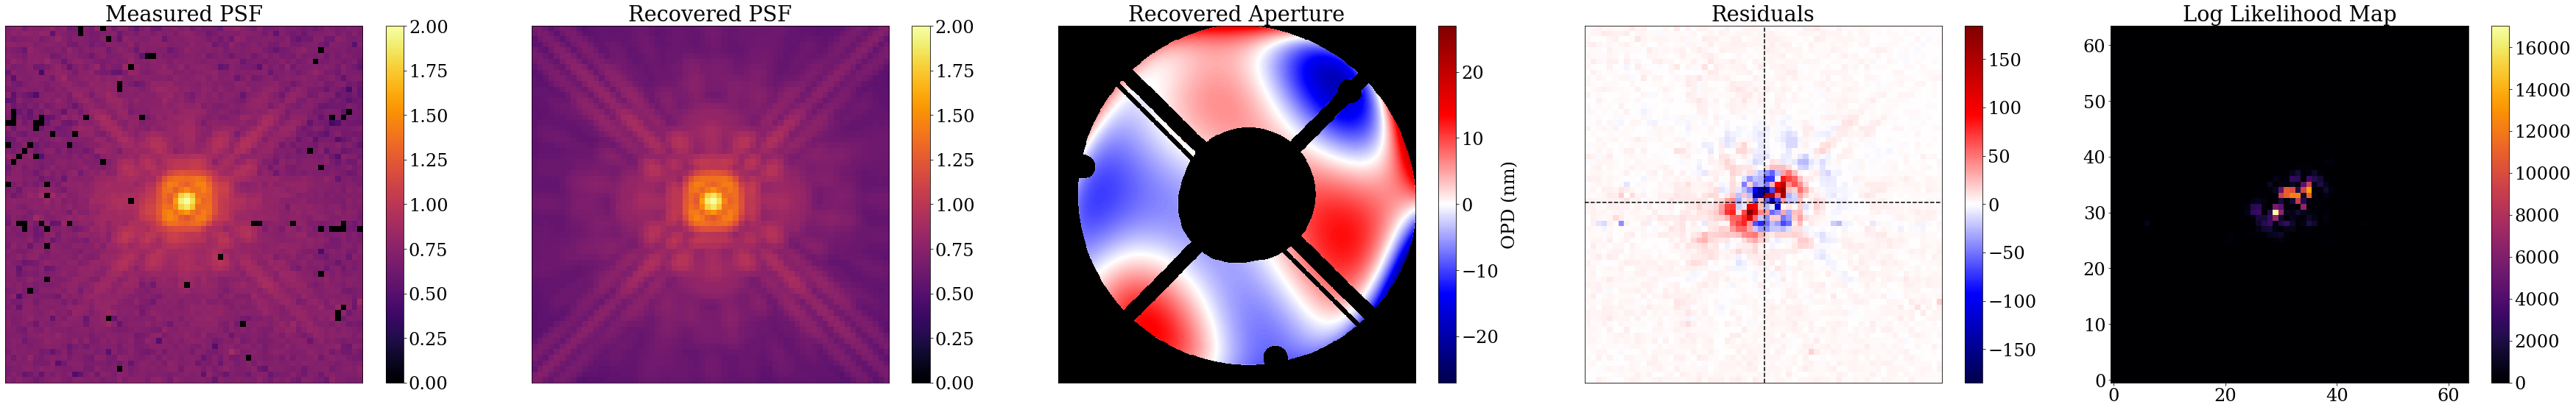

In [436]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,5, figsize=(50,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[2]


model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

#start_aberrations = model.get(exp.fit.map_param(exp, "start_aberrations"))#*1e-9
#end_aberrations = model.get(exp.fit.map_param(exp, "end_aberrations"))#*1e-9

#aberrations_model = model.set(exp.map_param("aberrations"), (start_aberrations+end_aberrations)/2)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

axs[3].axvline((wid-1)/2 + params.get(exp.map_param("positions"))[0], color='k',linestyle='--')
axs[3].axhline((wid-1)/2 + params.get(exp.map_param("positions"))[1], color='k',linestyle='--')


lpdf = posterior(model,exp,return_im=True)#*nanmap
lpd = axs[4].imshow(lpdf)
plt.colorbar(lpd, ax=axs[4])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")
axs[4].set_title("Log Likelihood Map")

for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


In [437]:
exposures[2].target

'U10764'

In [438]:
params.params["spectrum"]

{'U10742_F110W': Array([-5.5965014e-02,  1.0929872e-04,  4.5771709e-01,  5.5090004e-01,
         1.8353797e-04,  9.4279653e-01,  1.0782607e+00,  1.1007588e+00,
         1.1361582e+00,  1.3010679e+00], dtype=float32),
 'U10764_F110W': Array([ 0.36346963, -0.20276602,  0.31515577,  0.15517028,  0.5723214 ,
         0.7304556 ,  0.9945731 ,  1.0920678 ,  1.1940829 ,  1.5066522 ],      dtype=float32),
 'U11296_F110W': Array([ 6.1652653e-02,  5.1825643e-03,  5.1121593e-01,  5.5307782e-01,
        -5.3191039e-04,  9.6035457e-01,  1.0655162e+00,  1.0889236e+00,
         1.1245083e+00,  1.2804524e+00], dtype=float32)}

In [439]:
potato

NameError: name 'potato' is not defined

In [ ]:
rc = True
fishers = calc_fishers(model, exposures, paths, recalculate=rc)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
fishers.keys()

dict_keys(['n8yj02wyq', 'n8yj53vfq'])

In [ ]:
spectrum_err = np.diag(np.sqrt(np.linalg.inv(fishers['n8yj02x0q']['spectrum'])))
spectrum_err

KeyError: 'n8yj02x0q'

In [ ]:
params.get("spectrum.F110W")/spectrum_err

Array([2.16416434e+01, 1.50275951e+00, 1.19860714e+01, 1.22610438e-05,
       4.68485012e-06, 4.49790384e-06, 8.50646723e-06, 1.37843430e+01,
       1.24133089e-05, 4.31208261e-06, 4.38312817e-06, 1.32389665e-05,
       1.04872391e+01, 4.29010031e+00, 3.14885869e+00], dtype=float64)

Text(0, 0.5, 'Relative Spectral Intensity')

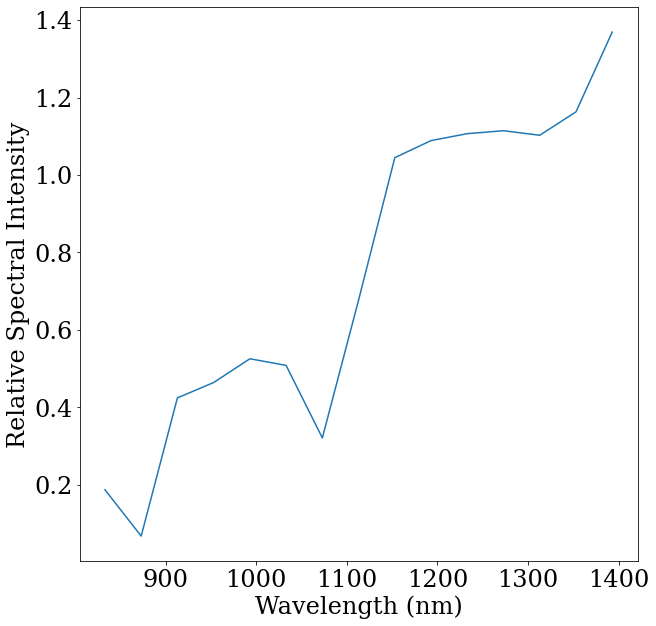

In [ ]:
plt.figure(figsize=(10,10))
swv = filter_files["F110W"][:,0]/10
wmin = np.min(swv)
wmax = np.max(swv)
woff = (wmax-wmin)*0.1

wavels = np.linspace(wmin+woff, wmax-woff, nwavels)
plt.plot(wavels, params.get("spectrum.F110W"))
#plt.errorbar(wavels, params.get("spectrum.F110W"), yerr = spectrum_err)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Intensity")

In [ ]:
len(swv)

71